<a href="https://colab.research.google.com/github/d22cs051/dlops-23/blob/main/assignment/D22CS051_Lab_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL-Ops Lab 2 fashion FashionMNIST Dataset

NOTE :-
* All the code written below is well formated and properly commented.
* All the visulization of images are done properly with matplot libs and explaned.
* All Loss and Accurcy curves can be seen in there respective sections.
* Please use table of content on google colab to glide throught different section respectively.
* Change runtime to gpu if possible.

## Checking Avilable GPU

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Importing requirements

In [2]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

# importing t-sne
from sklearn.manifold import TSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 6.1 MB/s eta 0:00:00


## device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Getting Dataset with pytorch

### Downloading Dataset

In [4]:
from torchvision import transforms

image_trasform = transforms.Compose(
    [
        # Not need to convert the images to gray scale
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.FashionMNIST(
    root = 'data/',
    download = True,
    train = True,
    transform = image_trasform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = 'data/',
    download = True,
    train = False,
    transform = image_trasform
)
train_dataset,test_dataset

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ), Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

### Vis. dataset (train dataset)

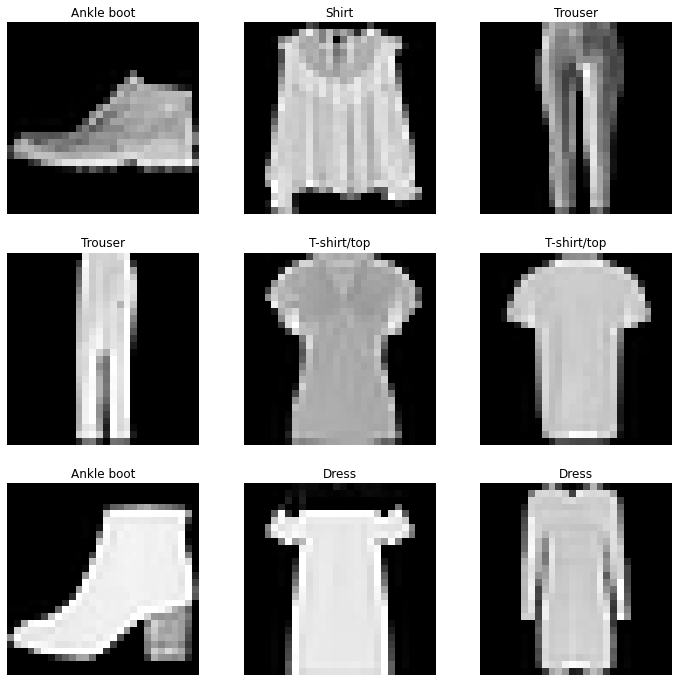

In [5]:
# randomly ploting image samples from the grayscale dataset
labels_map = test_dataset.class_to_idx # getting class -> index map
labels_map = dict(map(reversed, labels_map.items())) # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(12, 12)) # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)) # randomely selecting one image sample from the image index
    # print("sample_idx: ",sample_idx)
    img, label = train_dataset[sample_idx.item()] # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i) 
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap="gray") # NOTE:- Color map is gray because we're having 1 channel images
    # sub plot code ends
plt.show()

### Converting dataset to dataloader

In [6]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count() # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers =  NUM_WORKERS   
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    drop_last = True,
    num_workers =  NUM_WORKERS   
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 469
Numbers of Batches in Test Dataloader: 78


In [7]:
next(iter(train_dataloader))[0].shape

torch.Size([128, 1, 28, 28])

## Training Noise AE model

### Defining model

In [8]:
class NoiseAE(nn.Module):
  f = nn.Flatten()
  def __init__(
      self,
      in_channels:int,
      hidden_units:int
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the data
      is_train_encoder: true if training encoder and not clf.
    '''
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(in_channels, hidden_units), # layer 1
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units), # layer 2
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units), # layer 3
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units), # layer 4
        nn.Sigmoid()
        )
    self.decoder = nn.Sequential(
        nn.Linear(hidden_units, hidden_units), # layer 1
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units), # layer 2
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units), # layer 3
        nn.Sigmoid(),
        nn.Linear(hidden_units, in_channels), # layer 4
        nn.Sigmoid(),
        )

  def encode(self, x):
      return self.encoder(x)

  def decode(self, z):
      return self.decoder(z)

  def forward(self, x):
    x = self.encode(x)
    return self.decode(x)

### making model object

In [9]:
height = next(iter(train_dataloader))[0].shape[2]
width = next(iter(train_dataloader))[0].shape[2]
height,width

(28, 28)

In [10]:
class_names = train_dataloader.dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
model_ae = NoiseAE(
    in_channels = height*width,
    hidden_units = 32
    ).to(device)
# print("\nMODEL INFO: \n")
# print(mdoel_0)

### train loop for denoising auto encoder

### Training the Noise Reduction Auto Encoder Model

In [12]:
def train_step_ae(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device
               ):
  train_loss =  0
  model.train()
  for (X,y) in data_loader:
    # Send data to GPU
    X, y = X.to(device), y.to(device)

    data = (X + 0.5 * torch.randn(X.shape).to(device))
    
    # 1. Forward pass
    y_pred = model(data.view(-1,height*width))

    # 2. Calculate loss
    loss = loss_fn(y_pred.view(-1,height*width), X.view(-1,height*width))
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | ",end="")
  return train_loss.item()

def test_step_ae(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss = 0
  model.eval() # put model in eval mode
  # Turn on inference context manager
  with torch.inference_mode(): 
      for (X, y) in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        test_pred = model(X.view(-1,height*width))
        
        # 2. Calculate loss and accuracy
        test_loss += loss_fn(test_pred, X.view(-1,height*width))
      
      # Adjust metrics and print out
      test_loss /= len(data_loader)
      print(f"Test loss: {test_loss:.5f}\n")
  return test_loss.item()


In [13]:
from tqdm.auto import tqdm as tqdm

def train_ae(model:nn.Module,epochs:int=5):
  result_dict = {"train_loss":[],"test_loss":[]}
  for epoch in tqdm(range(epochs)):
    print(f"EPOCH: {epoch} | ",end="")
    result_dict["train_loss"].append( train_step_ae(model,train_dataloader,loss_fn,optimizer,device) )
    result_dict["test_loss"].append( test_step_ae(model,test_dataloader,loss_fn,device) )
  return result_dict


# init. epochs
NUM_EPOCHS = 50

# init. loss function, accuracy function and optimizer
loss_fn = nn.MSELoss()
# acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_ae.parameters(), lr=1e-2)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_ae_results = train_ae(model=model_ae,
                        epochs=NUM_EPOCHS
                        )

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0 | Train loss: 0.07655 | Test loss: 0.05872

EPOCH: 1 | Train loss: 0.05452 | Test loss: 0.05131

EPOCH: 2 | Train loss: 0.04986 | Test loss: 0.04679

EPOCH: 3 | Train loss: 0.04333 | Test loss: 0.04050

EPOCH: 4 | Train loss: 0.03889 | Test loss: 0.03672

EPOCH: 5 | Train loss: 0.03649 | Test loss: 0.03435

EPOCH: 6 | Train loss: 0.03506 | Test loss: 0.03294

EPOCH: 7 | Train loss: 0.03379 | Test loss: 0.03262

EPOCH: 8 | Train loss: 0.03281 | Test loss: 0.03156

EPOCH: 9 | Train loss: 0.03206 | Test loss: 0.03035

EPOCH: 10 | Train loss: 0.03161 | Test loss: 0.03045

EPOCH: 11 | Train loss: 0.03129 | Test loss: 0.02980

EPOCH: 12 | Train loss: 0.03106 | Test loss: 0.02969

EPOCH: 13 | Train loss: 0.03074 | Test loss: 0.02930

EPOCH: 14 | Train loss: 0.03070 | Test loss: 0.02959

EPOCH: 15 | Train loss: 0.03054 | Test loss: 0.02902

EPOCH: 16 | Train loss: 0.03040 | Test loss: 0.02892

EPOCH: 17 | Train loss: 0.03020 | Test loss: 0.02861

EPOCH: 18 | Train loss: 0.03016 | Test

### passing image throught encoder-decoder and vis. the results

||| Before passing throught Encoder Pipeline|||


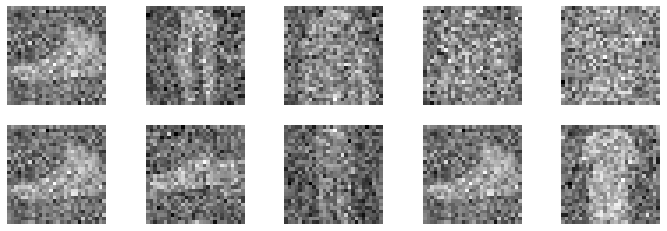

||| After passing throught Encoder Pipeline|||


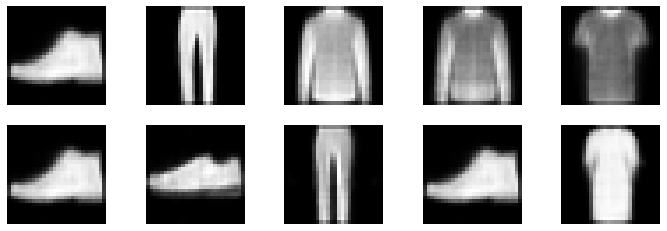

In [14]:
one_batch_sample = next(iter(test_dataloader))
X, y = one_batch_sample[0].to(device), one_batch_sample[1].to(device)
X = (X + 0.5 * torch.randn(X.shape).to(device))
rand_idx = np.random.randint(low = 0, high = len(X),size=(5*2))
figure = plt.figure(figsize=(12, 4))
print("||| Before passing throught Encoder Pipeline|||")
for i in range(5*2):
  figure.add_subplot(2,5,i+1)
  plt.imshow(X[rand_idx[i]].cpu().squeeze().numpy(),cmap = "gray")
  plt.axis("off")
plt.show()

print("||| After passing throught Encoder Pipeline|||")
with torch.inference_mode():
  new_images = model_ae(X.view(-1,height*width)).reshape(BATCH_SIZE,1,28,28)
  figure = plt.figure(figsize=(12, 4))
  for i in range(5*2):
    figure.add_subplot(2,5,i+1)
    plt.imshow(new_images[rand_idx[i]].cpu().squeeze().numpy(),cmap = "gray")
    # print((new_images[rand_idx[1]].cpu().squeeze().numpy() == new_images[rand_idx[i]].cpu().squeeze().numpy()).all())
    plt.axis("off")
  plt.show()

### plot loss graphs

#### Defining Plot Fucntion

In [15]:
from typing import Dict,List

def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Desc:
      Plots training curves of a results dictionary.

    Args:
      results (dict): dictionary containing list of values, e.g.
          {"train_loss": [...],
            "train_acc": [...],
            "test_loss": [...],
            "test_acc": [...]}
    """
    acc_flag = True

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    try:
      accuracy = results['train_acc']
      test_accuracy = results['test_acc']
    except:
      acc_flag = False
    

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    if acc_flag:
      plt.subplot(1, 2, 2)
      plt.plot(epochs, accuracy, label='train_accuracy')
      plt.plot(epochs, test_accuracy, label='test_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()
      plt.show()

### Ploting Curve for Noisy Auto Encoder

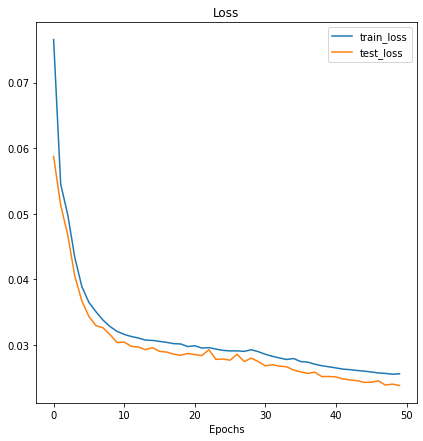

In [16]:
plot_loss_curves(model_ae_results)
# model_ae_results

### Ploting T-SNE

In [17]:
tsne = TSNE(n_components=2, random_state=42,learning_rate='auto',init='random', perplexity=5)

In [18]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.inference_mode():
  for img, lb in test_dataloader:
    embed = model_ae.encode(img.to(device).view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break


In [19]:
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [20]:
embed_tensor.shape,label_tensor

(torch.Size([1024, 32]), tensor([9, 2, 1,  ..., 2, 3, 8]))

In [21]:
tsne_data = tsne.fit_transform(embed_tensor)

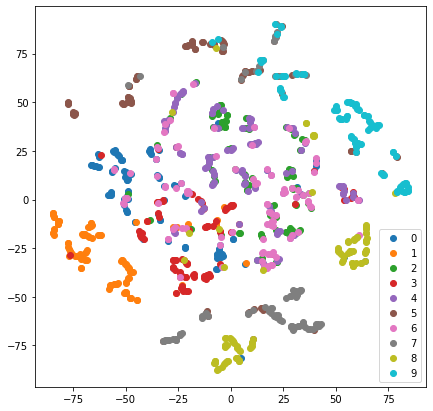

In [22]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

## Making classifer Class Model 1 FC

### Defining Model class

In [23]:
class Clf1FC(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the data
    '''
    super().__init__()
    self.clf = nn.Sequential(
        nn.Linear(in_channels, hidden_units), # FC layer 1
        nn.Sigmoid(),
        nn.Linear(hidden_units, out_channels), # output layer 1
        nn.Sigmoid(),
        )

  def forward(self, x):
    x = model_ae.encode(x)
    # print(x.shape)
    x = self.clf(x)
    # print(x.shape)
    return x

### Making object Model

In [24]:
model_fc1_ac = Clf1FC(
    in_channels = 32,# must be same as Encoder Output
    hidden_units = 32,
    out_channels = len(class_names)
    ).to(device)

model_fc1_ac

Clf1FC(
  (clf): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): Sigmoid()
  )
)

### Training Model Clf1FC

In [25]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str
    ):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train() # putting model in traing model

    train_loss, train_acc = 0, 0 # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X,y) in dataloader: # loop in batches
      # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
      X,y = X.to(device), y.to(device) # sending the data to target device
      # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

      # 1. forward pass
      y_pred_logits = model(X.view(-1,height*width))

      # 2. calculate the loss
      loss = loss_fn(y_pred_logits, y)
      train_loss += loss.item()

      # 3. optimizer zero grad
      optimizer.zero_grad()

      # 4. loss backword
      loss.backward()

      # 5. optimizer step
      optimizer.step()

      train_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss/len(dataloader), train_acc/len(dataloader)


def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str
    ):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval() # putting model in eval model

    test_loss, test_acc = 0, 0 # initlizing loss and acc. for the epoch

    with torch.inference_mode():
      for (X,y) in dataloader: # loop in batches
        X,y = X.to(device), y.to(device) # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X.view(-1,height*width))

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.
    return test_loss/len(dataloader), test_acc/len(dataloader)


from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    epochs: int,
    regularizer = None,
    dropout = None,
  ):
  """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      regularizer (function) = None: A penalty function
      dropout (function) = None: A dropout function takes input -> random_drop_neuron(model: nn.Module,seed:int = 42)
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
  """
  # 1. init. result dict
  result_dict = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # 2. loop in range epochs performs train and test steps on the model
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            acc_fn=acc_fn,
                                            optimizer=optimizer,
                                            device=device
                                          )

    test_loss, test_acc = testing_step(
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        device=device
                                      )
  
  # 3. print out results
    print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )
    
  # 4. adding results to result_dict
    result_dict["train_loss"].append(train_loss)
    result_dict["train_acc"].append(train_acc)
    result_dict["test_loss"].append(test_loss)
    result_dict["test_acc"].append(test_acc)

  # 5. return result dict
  return result_dict


In [26]:
# init. epochs
NUM_EPOCHS = 15

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_fc1_ac.parameters(), lr=1e-2)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_fc1_ac_result = train(model=model_fc1_ac, 
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      device=device,
      loss_fn=loss_fn, 
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8116 | train_acc: 0.4905 | test_loss: 1.6900 | test_acc: 0.5871
Epoch: 2 | train_loss: 1.6693 | train_acc: 0.6151 | test_loss: 1.6606 | test_acc: 0.6558
Epoch: 3 | train_loss: 1.6575 | train_acc: 0.6294 | test_loss: 1.6549 | test_acc: 0.6296
Epoch: 4 | train_loss: 1.6489 | train_acc: 0.6795 | test_loss: 1.6424 | test_acc: 0.7158
Epoch: 5 | train_loss: 1.6393 | train_acc: 0.7103 | test_loss: 1.6360 | test_acc: 0.7169
Epoch: 6 | train_loss: 1.6356 | train_acc: 0.7094 | test_loss: 1.6345 | test_acc: 0.7168
Epoch: 7 | train_loss: 1.6336 | train_acc: 0.7150 | test_loss: 1.6321 | test_acc: 0.7171
Epoch: 8 | train_loss: 1.6313 | train_acc: 0.7115 | test_loss: 1.6300 | test_acc: 0.7110
Epoch: 9 | train_loss: 1.6300 | train_acc: 0.7122 | test_loss: 1.6298 | test_acc: 0.7106
Epoch: 10 | train_loss: 1.6291 | train_acc: 0.7103 | test_loss: 1.6287 | test_acc: 0.7103
Epoch: 11 | train_loss: 1.6285 | train_acc: 0.7113 | test_loss: 1.6278 | test_acc: 0.7084
Epoch: 12 | train_l

### plot Model Clf1FC

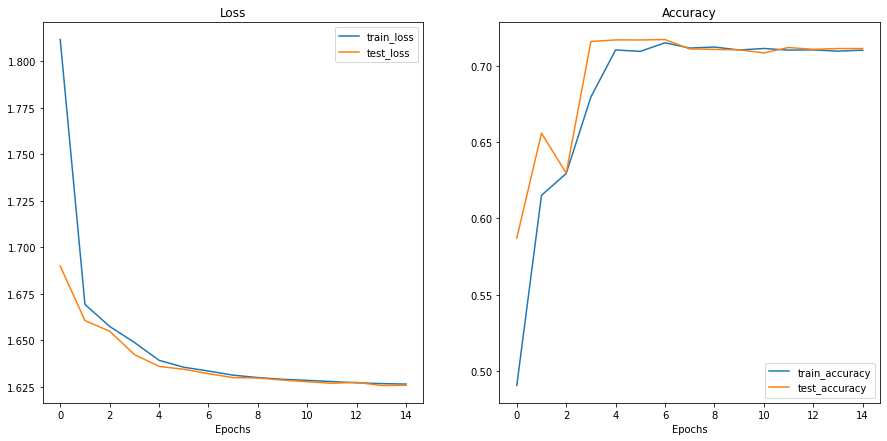

In [27]:
plot_loss_curves(model_fc1_ac_result)

### Reconstruction of noisy image

||| Before passing throught Encoder Pipeline|||


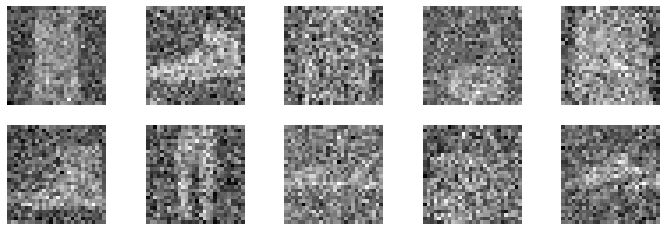

||| After passing throught Encoder Pipeline|||


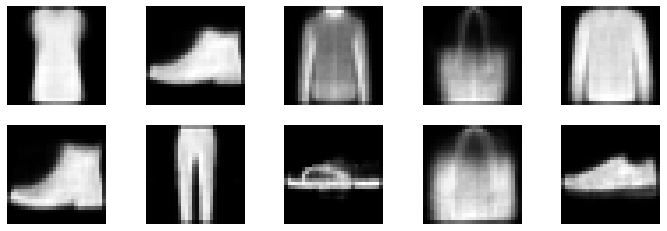

In [28]:
one_batch_sample = next(iter(test_dataloader))
X, y = one_batch_sample[0].to(device), one_batch_sample[1].to(device)
X = (X + 0.5 * torch.randn(X.shape).to(device))
rand_idx = np.random.randint(low = 0, high = len(X),size=(5*2))
figure = plt.figure(figsize=(12, 4))
print("||| Before passing throught Encoder Pipeline|||")
for i in range(5*2):
  figure.add_subplot(2,5,i+1)
  plt.imshow(X[rand_idx[i]].cpu().squeeze().numpy(),cmap = "gray")
  plt.axis("off")
plt.show()

print("||| After passing throught Encoder Pipeline|||")
with torch.inference_mode():
  new_images = model_ae(X.view(-1,height*width)).reshape(BATCH_SIZE,1,28,28)
  figure = plt.figure(figsize=(12, 4))
  for i in range(5*2):
    figure.add_subplot(2,5,i+1)
    plt.imshow(new_images[rand_idx[i]].cpu().squeeze().numpy(),cmap = "gray")
    # print((new_images[rand_idx[1]].cpu().squeeze().numpy() == new_images[rand_idx[i]].cpu().squeeze().numpy()).all())
    plt.axis("off")
  plt.show()

### Ploting T-SNE

In [29]:
tsne = TSNE(n_components=2, random_state=42,learning_rate='auto',init='random', perplexity=5)

In [30]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.inference_mode():
  for img, lb in test_dataloader:
    embed = model_fc1_ac(img.to(device).view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break


In [31]:
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [32]:
embed_tensor.shape,label_tensor

(torch.Size([1024, 10]), tensor([9, 2, 1,  ..., 2, 3, 8]))

In [33]:
tsne_data = tsne.fit_transform(embed_tensor)

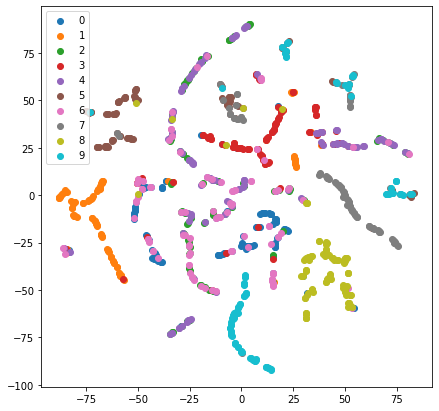

In [34]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

## Making classifer Class Model 3 FC

### Defining Model class

In [35]:
class Clf3FC(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the data
    '''
    super().__init__()
    self.clf = nn.Sequential(
        nn.Linear(in_channels, hidden_units), # FC layer 1
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units), # FC layer 2
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units), # FC layer 3
        nn.Sigmoid(),
        nn.Linear(hidden_units, out_channels), # output layer 1
        nn.Sigmoid(),
        )

  def forward(self, x):
    x = model_ae.encode(x)
    # print(x.shape)
    x = self.clf(x)
    # print(x.shape)
    return x

### Making object Model

In [36]:
model_fc3_ac = Clf3FC(
    in_channels = 32,# must be same as Encoder Output
    hidden_units = 32,
    out_channels = len(class_names)
    ).to(device)

model_fc3_ac

Clf3FC(
  (clf): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): Sigmoid()
  )
)

### Training Model Clf3FC

In [37]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str
    ):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train() # putting model in traing model

    train_loss, train_acc = 0, 0 # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X,y) in dataloader: # loop in batches
      # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
      X,y = X.to(device), y.to(device) # sending the data to target device
      # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

      # 1. forward pass
      y_pred_logits = model(X.view(-1,height*width))

      # 2. calculate the loss
      loss = loss_fn(y_pred_logits, y)
      train_loss += loss.item()

      # 3. optimizer zero grad
      optimizer.zero_grad()

      # 4. loss backword
      loss.backward()

      # 5. optimizer step
      optimizer.step()

      train_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss/len(dataloader), train_acc/len(dataloader)


def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str
    ):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval() # putting model in eval model

    test_loss, test_acc = 0, 0 # initlizing loss and acc. for the epoch

    with torch.inference_mode():
      for (X,y) in dataloader: # loop in batches
        X,y = X.to(device), y.to(device) # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X.view(-1,height*width))

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.
    return test_loss/len(dataloader), test_acc/len(dataloader)


from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    epochs: int,
    regularizer = None,
    dropout = None,
  ):
  """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      regularizer (function) = None: A penalty function
      dropout (function) = None: A dropout function takes input -> random_drop_neuron(model: nn.Module,seed:int = 42)
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
  """
  # 1. init. result dict
  result_dict = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # 2. loop in range epochs performs train and test steps on the model
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            acc_fn=acc_fn,
                                            optimizer=optimizer,
                                            device=device
                                          )

    test_loss, test_acc = testing_step(
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        device=device
                                      )
  
  # 3. print out results
    print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )
    
  # 4. adding results to result_dict
    result_dict["train_loss"].append(train_loss)
    result_dict["train_acc"].append(train_acc)
    result_dict["test_loss"].append(test_loss)
    result_dict["test_acc"].append(test_acc)

  # 5. return result dict
  return result_dict


In [38]:
# init. epochs
NUM_EPOCHS = 15

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_fc3_ac.parameters(), lr=1e-2)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_fc3_ac_result = train(model=model_fc3_ac, 
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      device=device,
      loss_fn=loss_fn, 
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8179 | train_acc: 0.3445 | test_loss: 1.7189 | test_acc: 0.3658
Epoch: 2 | train_loss: 1.7153 | train_acc: 0.3524 | test_loss: 1.7109 | test_acc: 0.3419
Epoch: 3 | train_loss: 1.7101 | train_acc: 0.3404 | test_loss: 1.7096 | test_acc: 0.3387
Epoch: 4 | train_loss: 1.7049 | train_acc: 0.3563 | test_loss: 1.7019 | test_acc: 0.3698
Epoch: 5 | train_loss: 1.7025 | train_acc: 0.3941 | test_loss: 1.7012 | test_acc: 0.3879
Epoch: 6 | train_loss: 1.6987 | train_acc: 0.4510 | test_loss: 1.6838 | test_acc: 0.4360
Epoch: 7 | train_loss: 1.6787 | train_acc: 0.4534 | test_loss: 1.6763 | test_acc: 0.4616
Epoch: 8 | train_loss: 1.6772 | train_acc: 0.4682 | test_loss: 1.6758 | test_acc: 0.4665
Epoch: 9 | train_loss: 1.6767 | train_acc: 0.4616 | test_loss: 1.6751 | test_acc: 0.4789
Epoch: 10 | train_loss: 1.6741 | train_acc: 0.4599 | test_loss: 1.6660 | test_acc: 0.4614
Epoch: 11 | train_loss: 1.6656 | train_acc: 0.4635 | test_loss: 1.6616 | test_acc: 0.4698
Epoch: 12 | train_l

### plot Model Clf3FC

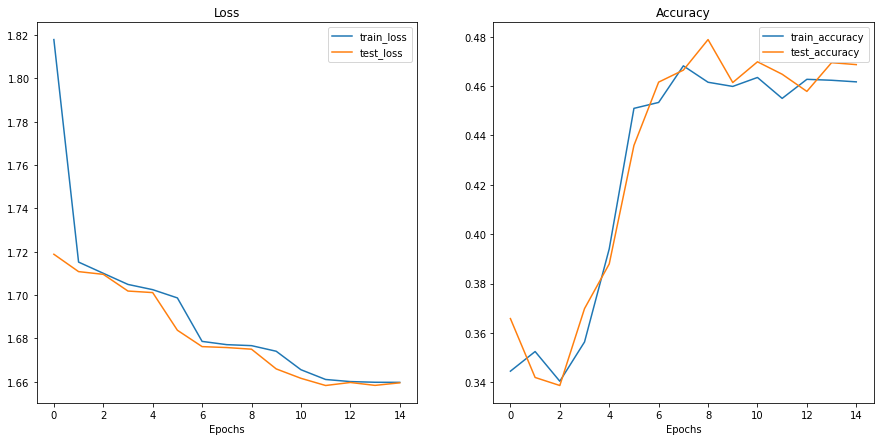

In [39]:
plot_loss_curves(model_fc3_ac_result)

### Reconstruction of noisy image

||| Before passing throught Encoder Pipeline|||


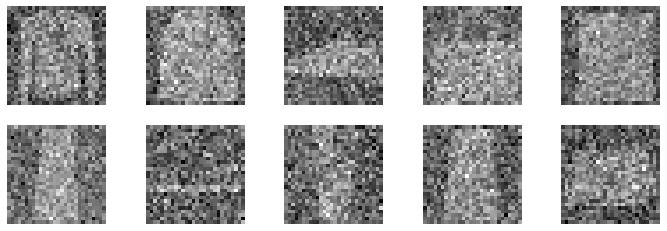

||| After passing throught Encoder Pipeline|||


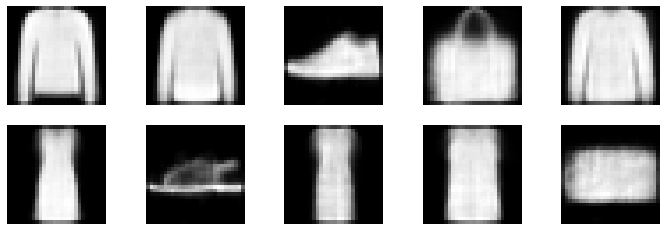

In [40]:
one_batch_sample = next(iter(test_dataloader))
X, y = one_batch_sample[0].to(device), one_batch_sample[1].to(device)
X = (X + 0.5 * torch.randn(X.shape).to(device))
rand_idx = np.random.randint(low = 0, high = len(X),size=(5*2))
figure = plt.figure(figsize=(12, 4))
print("||| Before passing throught Encoder Pipeline|||")
for i in range(5*2):
  figure.add_subplot(2,5,i+1)
  plt.imshow(X[rand_idx[i]].cpu().squeeze().numpy(),cmap = "gray")
  plt.axis("off")
plt.show()

print("||| After passing throught Encoder Pipeline|||")
with torch.inference_mode():
  new_images = model_ae(X.view(-1,height*width)).reshape(BATCH_SIZE,1,28,28)
  figure = plt.figure(figsize=(12, 4))
  for i in range(5*2):
    figure.add_subplot(2,5,i+1)
    plt.imshow(new_images[rand_idx[i]].cpu().squeeze().numpy(),cmap = "gray")
    # print((new_images[rand_idx[1]].cpu().squeeze().numpy() == new_images[rand_idx[i]].cpu().squeeze().numpy()).all())
    plt.axis("off")
  plt.show()

### Ploting T-SNE

In [41]:
tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='random', perplexity=5)

In [42]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.inference_mode():
  for img, lb in test_dataloader:
    embed = model_fc3_ac(img.to(device).view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break


In [43]:
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [44]:
embed_tensor.shape,label_tensor

(torch.Size([1024, 10]), tensor([9, 2, 1,  ..., 2, 3, 8]))

In [45]:
tsne_data = tsne.fit_transform(embed_tensor)

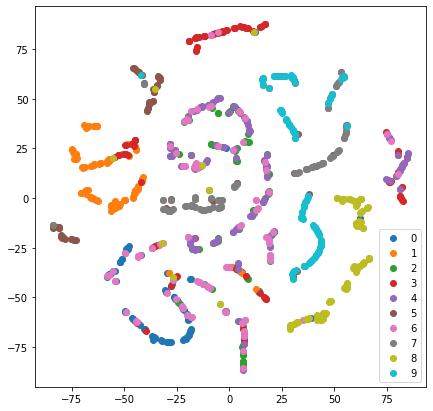

In [46]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()